# **BBM409 ASSIGNMENT 1**

## **PART 1: Glass Material Classification with KNN**

In the first part of the assignment, we implemented a nearest neighbor algorithm to classify glass types of different glass. Below we put a copy of our code with some explanations. After code parts there will be analysis part for each one.

### Glass Classification Dataset

* Dataset consists of 214 samples with discrete 6 class types{”1”, ”2”, ”3”, ”5”, ”6”, ”7”})
* Attribute Information:
    1. RI: refractive index
    2. Na: Sodium
    3. Mg: Magnesium
    4. Al: Aluminum
    5. Si: Silicon
    6. K: Potassium
    7. Ca: Calcium
    8. Ba: Barium
    9. Fe: Iron
    10. Type: Type of glass: (class attribute)

In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### K-Fold Cross Validation
Before starting we split our training dataset into two sets; training set which will be used to learn model, and
test set which will be used to measure the success of our model. For this purpose we use K-Fold cross-validation. In 5-Folds Cross Validation, we divide our data into 5 different subsets. We use 4 subsets to train our data and leave the final subset as test data. In our data there is 214 rows so wen we split our data into 5 equal parts there will be 5 sets each containing 43,43,43,43 an 42 rows (43+43+43+43+43=214).

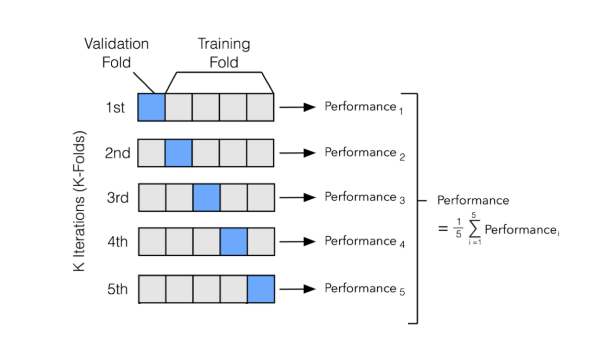

### Classification Performance Metric: Accuracy

Accuracy is simply the ratio of correctly predicted observation to the total observations. Below we can achieve it by calculating euclidean distaces between the test data and train data and then using knn algorithm make predictions. The formula for Accuracy is 
$ Accuracy = 100 ∗ \frac{number of correctly classified examples}{number of examples} $

In [2]:
def k_fold(x, is_weighted):
    # start and end points of each fold (for 214 rows of data 43+43+43+43+42)
    arr = [0, 43, 86, 129, 172, 215]
    # for each fold, we create our test and train set and then call KNN classification function
    for i in range(5):
        # 1/5 part of the data set as test data
        x_test = x[arr[i]:arr[i + 1]]

        # rest of the data set as train data
        a = x[0:arr[i]]
        b = x[arr[i + 1]:]
        x_train = np.concatenate((a, b), axis=0)

        print("--------------------------FOLD", i+1, "--------------------------------------------")

        # for every fold use knn classification
        knn_true_prediction_count, knn_false_prediction_count = knn_classification(x_train, x_test, is_weighted)

        list_accuracy = []

        # for eack k values {1,3,5,7,9}, we calculate accuracy seperately
        for e in range(0, 9, 2):
            accuracy = \
                (100 * knn_true_prediction_count[e]) / (knn_true_prediction_count[e] + knn_false_prediction_count[e])
            print("Accuracy for k=", (e + 1), " : ", accuracy)
            list_accuracy.append(accuracy)

        plt.plot([1, 3, 5, 7, 9], list_accuracy)
        plt.axis([0, 9, 0, 100])
    return

### Normalization

We do normalization as described for each element in each row;    
$ ni = \frac{fi − min(f)}{max(f) − min(f)} $  
Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. This way our predictions be more precise and meaningful.

In [3]:
def normalize(x):
    # for each column 
    for i in range(0, x.shape[1] - 2):
        col = []
        # for each row of that specific column
        for k in range(x.shape[0]):
            # get all the values of the specific column
            col.append(x[k, i])
        # sort the column array so the first index contains min value, last index contains max value for that cloumn
        col.sort()
        min_of_col = col[0]
        max_of_col = col[x.shape[0] - 1]

        # for each element in that column normalize one by one
        for j in range(x.shape[0]):
            x[j, i] = (x[j, i] - min_of_col) / (max_of_col - min_of_col)
            
    return x

In [4]:
# for unweighted KNN cases, we use this function to predict test datas classes  
def calculate_predictions(x_train, sorted_keys, test, true_prediction, false_prediction):
    closest_points = []
    for i in range(9):
        # in every loop, add one more nearest neighbor to the closest_points array
        closest_points.append(x_train[sorted_keys[i]][9])
        
        # when k=1 -> i=0  (length of closest_points array=1)
        #      k=3 -> i=2  (length of closest_points array=3)
        #      k=5 -> i=4  (length of closest_points array=5)
        #      k=7 -> i=6  (length of closest_points array=7)
        #      k=9 -> i=8  (length of closest_points array=9)
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:
            # get the most frequent output in the closest_points array
            frequent = max(set(closest_points), key=closest_points.count)
            
            # if the predicted class equals to the actual class, increment true prediction count
            # or else increment false prediction count
            if frequent == test[9]:
                true_prediction[i] += 1
            else:
                false_prediction[i] += 1

    return true_prediction, false_prediction

In [5]:
# for weighted KNN cases, we use this function to predict test datas classes  
def calculate_weighted_predictions(x_train, sorted_keys, euclidean_distances, test, true_prediction, false_prediction):
    # in closest_points_and_weights dictionary there are class numbers and their weights equals to 0 at beginning
    # key=class number , value=weight
    closest_points_and_weights = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
    for i in range(9):
        index = sorted_keys[i]
        # for each neighbor calculate weight as (1/distance) and add it to the dictionary
        if euclidean_distances.get(index) != 0:
            closest_points_and_weights[x_train[sorted_keys[i]][9]] += 1 / euclidean_distances.get(index)
        else:
            closest_points_and_weights[x_train[sorted_keys[i]][9]] += math.inf
            
        # find the maximum weighted class to predict 
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:
            frequent = max(closest_points_and_weights, key=closest_points_and_weights.get)
            
            # if the predicted class equals to the actual class, increment true prediction count
            # or else increment false prediction count
            if frequent == test[9]:
                true_prediction[i] += 1
            else:
                false_prediction[i] += 1

    return true_prediction, false_prediction

### K Nearest Neighbors Classification

The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. In k-NN classification, the output is a class. An object is classified by a vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. In our case we make k = 1,3,5,7,9 and then observe the results. With this observations we can choose amongst the k values which is the most logical one.

When computing K nearest neighbors we use euclidean distance between points. In our case, the data has 9 features so we compute euclidean distance in 9 dimensions. The euclidean distance computed as follows:
$ Euclidean Distance = \sqrt [2]{(x1_{i}-x1_{j})^2+(x2_{i}-x2_{j})^2 + (x3_{i}-x3_{j})^2 + (x4_{i}-x4_{j})^2 + ((x5_{i}-x5_{j})^2 + (x6_{i}-x6_{j})^2 + (x7_{i}-x7_{j})^2 + (x8_{i}-x8_{j})^2 + (x9_{i}-x9_{j})^2} $  

In [6]:
def knn_classification(x_train, x_test, is_weighted):
    # indices of the array represents k in kNN (we only use 1-3-5-7-9)
    true_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    false_prediction = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    # for each row in the test set, calculate euclidean distance
    for i in range(x_test.shape[0]):
        test = x_test[i]
        euclidean_distances = {}
        for j in range(0, x_train.shape[0]):
            ri = x_train[j][0] - test[0]
            na = x_train[j][1] - test[1]
            mg = x_train[j][2] - test[2]
            al = x_train[j][3] - test[3]
            si = x_train[j][4] - test[4]
            k = x_train[j][5] - test[5]
            ca = x_train[j][6] - test[6]
            ba = x_train[j][7] - test[7]
            fe = x_train[j][8] - test[8]
            euc_dist = math.sqrt(
                (ri * ri) + (ca * ca) + (mg * mg) + (na * na) + (al * al) + (si * si) + (k * k) + (ba * ba) + (fe * fe))

            euclidean_distances[j] = euc_dist

        # sort by the value of euclidean distance, first element will be the nearest point
        sorted_keys = sorted(euclidean_distances, key=euclidean_distances.get)

        # get the only first 9 nearest points because we dont need more for prediction
        sorted_keys = sorted_keys[:9]

        if is_weighted == False:
            # classify predictions as true or false by looking first 1,3,5,7,9 neighbors
            true_prediction, false_prediction = calculate_predictions(x_train, sorted_keys, test,
                                                                      true_prediction, false_prediction)
        else:
            # classify predictions with weights as true or false by looking first 1,3,5,7,9 neighbors
            true_prediction, false_prediction = calculate_weighted_predictions(x_train, sorted_keys,
                                                                               euclidean_distances,
                                                                               test, true_prediction, false_prediction)

    return true_prediction, false_prediction

In [7]:
def knn(x):
    print("KNN\n")
    k_fold(x, False)
    plt.ylabel("Accuracy")
    plt.xlabel("K value in KNN")
    plt.show()

In [8]:
def knn_with_normalization(x):
    print("KNN WITH NORMALIZATION\n")
    x = normalize(x)
    k_fold(x, False)
    plt.ylabel("Accuracy")
    plt.xlabel("K value in KNN with Normalization")
    plt.show()

In [9]:
def weighted_knn(x):
    print("WEIGHTED KNN\n")
    k_fold(x, True)
    plt.ylabel("Accuracy")
    plt.xlabel("K value in Weighted KNN")
    plt.show()

In [10]:
def weighted_knn_with_normalization(x):
    print("WEIGHTED KNN WITH NORMALIZATION\n")
    x = normalize(x)
    k_fold(x, True)
    plt.ylabel("Accuracy")
    plt.xlabel("K value in Weighted KNN with Normalization")
    plt.show()

In [11]:
# reading datas in the csv file to the numpy array
df = pd.read_csv('glass.csv')
x = np.array(df.iloc[:, :])

# shuffle the data
np.random.seed(101)
np.random.shuffle(x)

KNN

--------------------------FOLD 1 --------------------------------------------
Accuracy for k= 1  :  72.09302325581395
Accuracy for k= 3  :  62.7906976744186
Accuracy for k= 5  :  55.81395348837209
Accuracy for k= 7  :  60.46511627906977
Accuracy for k= 9  :  58.13953488372093
--------------------------FOLD 2 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  69.76744186046511
Accuracy for k= 5  :  74.4186046511628
Accuracy for k= 7  :  62.7906976744186
Accuracy for k= 9  :  65.11627906976744
--------------------------FOLD 3 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  67.44186046511628
Accuracy for k= 5  :  58.13953488372093
Accuracy for k= 7  :  60.46511627906977
Accuracy for k= 9  :  65.11627906976744
--------------------------FOLD 4 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  65.11627906976744
Accura

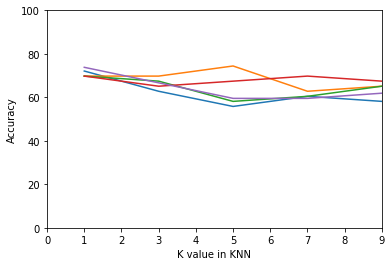

In [12]:
# KNN function
knn(x.copy())

KNN WITH NORMALIZATION

--------------------------FOLD 1 --------------------------------------------
Accuracy for k= 1  :  72.09302325581395
Accuracy for k= 3  :  67.44186046511628
Accuracy for k= 5  :  65.11627906976744
Accuracy for k= 7  :  60.46511627906977
Accuracy for k= 9  :  62.7906976744186
--------------------------FOLD 2 --------------------------------------------
Accuracy for k= 1  :  76.74418604651163
Accuracy for k= 3  :  76.74418604651163
Accuracy for k= 5  :  74.4186046511628
Accuracy for k= 7  :  67.44186046511628
Accuracy for k= 9  :  72.09302325581395
--------------------------FOLD 3 --------------------------------------------
Accuracy for k= 1  :  74.4186046511628
Accuracy for k= 3  :  69.76744186046511
Accuracy for k= 5  :  62.7906976744186
Accuracy for k= 7  :  65.11627906976744
Accuracy for k= 9  :  62.7906976744186
--------------------------FOLD 4 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  67.4418

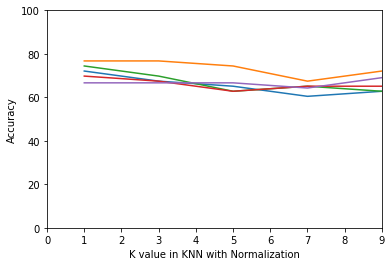

In [13]:
# KNN with normalization function
knn_with_normalization(x.copy())

WEIGHTED KNN

--------------------------FOLD 1 --------------------------------------------
Accuracy for k= 1  :  72.09302325581395
Accuracy for k= 3  :  65.11627906976744
Accuracy for k= 5  :  65.11627906976744
Accuracy for k= 7  :  65.11627906976744
Accuracy for k= 9  :  65.11627906976744
--------------------------FOLD 2 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  69.76744186046511
Accuracy for k= 5  :  72.09302325581395
Accuracy for k= 7  :  67.44186046511628
Accuracy for k= 9  :  72.09302325581395
--------------------------FOLD 3 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  67.44186046511628
Accuracy for k= 5  :  62.7906976744186
Accuracy for k= 7  :  65.11627906976744
Accuracy for k= 9  :  67.44186046511628
--------------------------FOLD 4 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3  :  69.7674418604

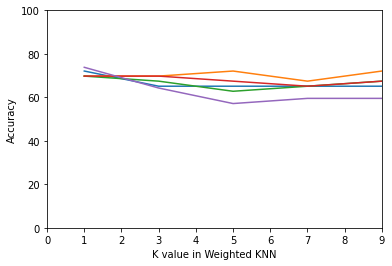

In [14]:
# Weighted KNN function
weighted_knn(x.copy())

WEIGHTED KNN WITH NORMALIZATION

--------------------------FOLD 1 --------------------------------------------
Accuracy for k= 1  :  72.09302325581395
Accuracy for k= 3  :  72.09302325581395
Accuracy for k= 5  :  69.76744186046511
Accuracy for k= 7  :  65.11627906976744
Accuracy for k= 9  :  62.7906976744186
--------------------------FOLD 2 --------------------------------------------
Accuracy for k= 1  :  76.74418604651163
Accuracy for k= 3  :  79.06976744186046
Accuracy for k= 5  :  81.3953488372093
Accuracy for k= 7  :  76.74418604651163
Accuracy for k= 9  :  83.72093023255815
--------------------------FOLD 3 --------------------------------------------
Accuracy for k= 1  :  74.4186046511628
Accuracy for k= 3  :  69.76744186046511
Accuracy for k= 5  :  69.76744186046511
Accuracy for k= 7  :  69.76744186046511
Accuracy for k= 9  :  65.11627906976744
--------------------------FOLD 4 --------------------------------------------
Accuracy for k= 1  :  69.76744186046511
Accuracy for k= 3 

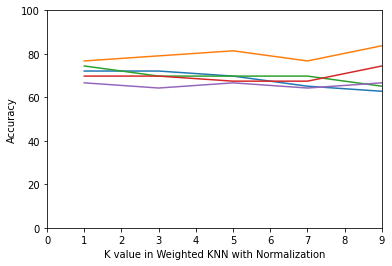

In [15]:
# Weighted KNN with normalization function
weighted_knn_with_normalization(x.copy())

## **Error Analysis for Classification**

Below you can see all of the accuracy values in one table.

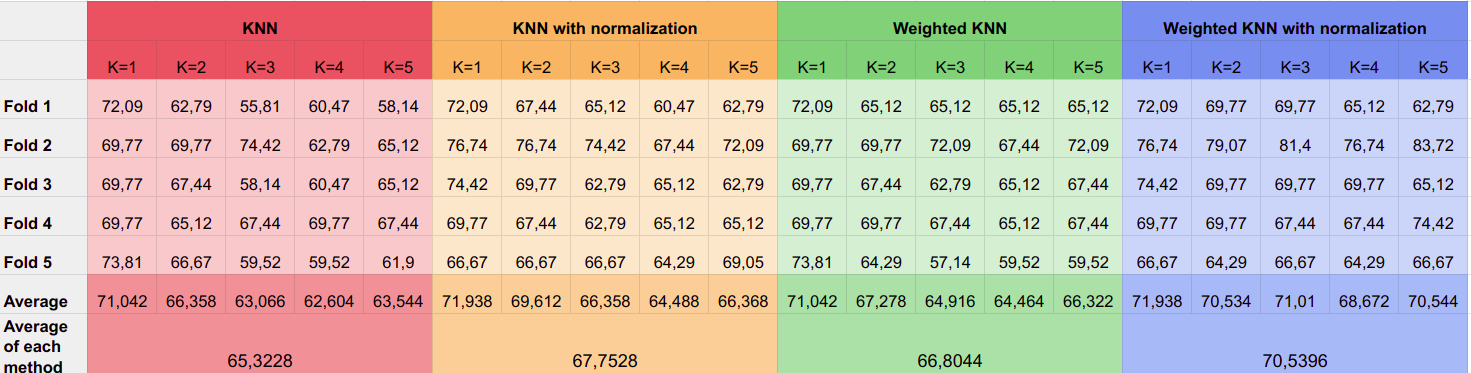

## **1.Possible Reasons to Misclassified Samples**

Find a few misclassified samples and comment on why you think they were hardto classify.

Here are some of the misclassified samples in different algoritm choices. Actually we examine more misclassififed samples and try to make predictions why those cases are harder to predict.

|ri|na|mg|al|si|k|ca|ba|fe|actual type|misclaffied type of sample|
|---|---|---|---|---|---|---|---|---|---|---|
|1.51115|17.38|0.0|0.34|75.41|0.0|6.65|0.0|0.0|**6**|**7**|
|1.52127|14.32|3.9|0.83|71.5|0.0|9.49|0.0|0.0|**3**|**1**|
|1.51653|11.95|0.0|1.19|75.18|2.7|8.93|0.0|0.0|**7**|**5**|

When we examined the misclassified samples, we realized that this could have happened for more than one reason. 
I think some of the reasons why it is hard to classify were;
* Imbalanced Data
* KNN without Normalization
* KNN without Weight
* Too Much or Irrelevant Features



#### **-Imbalanced Data**
What I mean by imbalanced data is the output of data is not distrubuted well. In our case "type" is our value for classify and if type values are not distributed well may be same types became harder to predict. Lets look at the distrubution of types in our data.


| Type of Glass | Number of occurences in data    |
|-------------- |---------------------------------|
| 2 | 76 |
| 1 | 70 |
| 7 | 29 |
| 3 | 17 |
| 5 | 13 |
| 6 | 9  |

The dataset is pretty unbalanced. The instances of types 1 and 2 constitute more than 67 % of the glass types. So in while type 1 and 2 gives more precise predictions other types may be misclassified. For example for the type 6 there is only 9 rows of data. Even if some of them are in the train set, it is very hard to predict while k values are increasing. As far as I observe most of the misclassified samples are the samples of least occured types.

#### **-KNN without Normalization** 

I found a misclassified example in the KNN portion of the assignment. And after looking at the table, I see that Simple KNN without normalization (even with weighted KNN) has less accuracy than other cases. When we look at the table,the accuracy of KNN is 65.32 and weighted KNN is 66.80, in other cases (normalized) it has 67.75 and 70.53 accuracy, respectively. Both cases with normalization have better accuracy. I think this may be the reason why the sample I found was misclassified, because normalization brings all the features to the same scale. The purpose of normalization is to change the values in the dataset to a common scale without disturbing the differences in the ranges of values. When we look at the values of the columns in our data set, some of them can have very different scales. One of the columns varies between 0.29 and 3.5, while the other column varies between 69.81 and 75.41. This difference in ranges can lead to less accuracy in when getting distances between points.

#### **-KNN without Weight**

The intuition behind weighted kNN, is to give more weight to the points which are nearby and less weight to the points which are farther away.In our cases there may be more misclassified samples while predicting without weight. As we see in the table while simple KNN has accuracy of 65,32, weighted KNN has accuracy of 66,8.Weighted KNN has more power to predict better. The difference is not so big but there is still a difference between them. 

#### **-Too Much or Irrelevant Features**

In our KNN function, we use all of the features to compute euclidean distance between points. In our case the points are in 9 dimension space and we compute euclidean distance in 9 dimensions. As the number of dimensions increases the size of the data space increases, and the amount of data needed to maintain density also increases. The k-nearest neighbors algorithm hinges on data points being close together.If our data is not dense enough in the space and the number of dimensions is big, the closest distance between two points approaches the average distance between points. 

Irrelevant features means may be some of the feautes in our data has no effect on the glass type. If a feature has less effect on the glass type than the other features but all features treated equally in the computation, that lead less performance in prediction. The irrelevant features effects makes it harder to predict precisely. 



## **2.Performance** 
Compare performance of different feature normalization choices and investigate the effect of important system parameters (number of training samples used, k in k-NN, etc.). Wherever relevant, feel free to discuss computation time in addition to classification rate.

#### **Different Feature Normalization Choices** 
Different feature normalization choices affects the accuracy. As we mention at the above part, the purpose of normalization is to change the values in the dataset to a common scale without disturbing the differences in the ranges of values. When we look at the values of the columns in our data set, some of them can have very different scales. Without normalization, some features which has large values with large ranges can affect predictions more than they should. The importance of the small values may not be noticed. In our data, as we see in the table the methods with normalization always higher accuracy than the other methods which is not normalized.

|            |Accuracy|
|------------|--------------------|
|KNN         |65,32|
|KNN with normalization|67,75|
|Weighted KNN|66,8|
|Weighted KNN with normalization |70,53|

Every case with normalization has higher accuracy, so we can say that normalization makes predictions more accurate.

#### **Effect of Different Methods**
What we mean by different methods is the 4 diffent algorithm choices.Those are KNN, KNN with normalization, weighted KNN and weighted KNN with normalization. We want to examine the effects of that methods to the accuracy. As we see from the table above the best method is weighted KNN with normalization which has accuracy of 70,53. After that KNN with normalization follows it by the value of accuracy is 67,75. So we can say that when we do normalization, there is better chance to predict more accurate. All the best cases include normalization. After that we can say that weighted KNN methods has better chance to achive accurate predictions. When we group algorithms by weighted/unweighted, average accuracy of weighted cases are higher.

#### **Effect of Important System Parameters**

* **Number of Training Samples**

With 5-Fold cross validation, we split our data into 5 equal sets. In each run different set of the data chosen to be test sample. The resting %80 part of the data used as training sample. ????? 

* **K in KNN**

We use 1,3,5,7,9 as k values in k-NN and calculate accuracy for every different k value. Below you can see average accuracy in all tests for different K values.

|        |**Average**|
|--------|-----------|
|K=1| 71,49|
|K=3| 68,4455|
|K=5| 66,3375|
|K=7| 65,057|
|K=9| 66,6945|

As we can see from the table although there are no big differences between k values, the best k value appears to be k=1 in our case. K=1 has average accuracy of 71,49 as a best result, and also k=3 is very close to it. As the k values get bigger the accuracy decreases, so we can say that larger k values has less accuracy. As far we observe that k=1 is the best k value for this situation.

#### **Computation Time**
Below we listed computation time as seconds versus algorithms. 
  
|            |Computation time (in seconds)|
|------------|--------------------|
|KNN         |1,0473731|
|KNN with normalization|1,0704601|
|Weighted KNN|1,0154355|
|Weighted KNN with normalization |1,0439775|

Although there is not much difference, we see that those with normalization take longer in miliseconds. KNN and weighted KNN are so similar and th other cases with normalization are similar too. I think that is because normalization happens in $ O(n^2) $ time. This addition to the algoritm may affect this elapsed time in miliseconds. Since our data is not very large this difference is not very obvious, but with bigger datas this will affect more.

**_________________________________________________________________________________________________________**

## **PART 2: Concrete Material Strength Estimation from Data**

* Dataset consists of 1030 samples with continuous concrete strength rate values.
* Attribute information for each sample in dataset:
    1. Cement
    2. Blast Furnace Slag
    3. Fly Ash
    4. Water
    5. Superplasticizer
    6. Coarse Aggregate
    7. Fine Aggregate
    8. Age
    9. Concrete compressive strength (”csMPa”, ground-truth strength value of cement material

Most of the code parts are same with the glass classification, only the methods for calculating ma is different in this one. Because they were mostly same code, we don't explain all over again.

In [16]:
def k_fold(x, is_weighted):
    # start and end points of each fold
    arr = [0, 206, 412, 618, 824, 1030]
    # for each fold, we create our test and train set and then call KNN classification function
    for i in range(5):
        # 1/5 part of the data set as test data
        x_test = x[arr[i]:arr[i + 1]]

        # rest of the data set as train data
        a = x[0:arr[i]]
        b = x[arr[i + 1]:]
        x_train = np.concatenate((a, b), axis=0)

        print()
        print("--------------------------FOLD", i+1, "--------------------------------------------")

        # for every fold use knn classification
        knn_maes = knn_classification(x_train, x_test, is_weighted)

        list_mae = []

        for e in range(0, 9, 2):
            mae = knn_maes[e] / len(x_test)
            print("MAE for k=", (e + 1), " : ", mae)
            list_mae.append(mae)

        plt.plot([1, 3, 5, 7, 9], list_mae)
        plt.axis([0, 9, 0, 10])
    return

In [17]:
def normalize(x):
    # for each column
    for i in range(0, x.shape[1]-1):
        col = []
        # for each row of that specific column
        for k in range(x.shape[0]):
            # get all the values of the specific column
            col.append(x[k, i])
        # sort the column array so the first index contains min value, last index contains max value for that column
        col.sort()
        min_of_col = col[0]
        max_of_col = col[x.shape[0]-1]
        # for each element in that column normalize one by one
        for j in range(x.shape[0]):
            x[j, i] = (x[j, i] - min_of_col) / (max_of_col - min_of_col)
    return x


### Mean Absolute Error

Mean Absolute Error is a formula for calculating amount of error in a set of predictions. It's the average of absolute difference between prediction and actual value. Below we sum all of the differences between actual and predicted values and divide this result to the number of test samples. Formula for Mean Absolute Error is: $ MAE = \frac{1}{n} * \sum_{i=1}^{n} | d_{i}- d̂_{i} | $

$d_{i}$ is the actual value\
$d̂_{i}$ is the predicted value\
$n$ is the number of samples

In [18]:
# for each element in that column normalize one by one
def calculate_predictions(x_train, sorted_keys, test, maes):
    closest_points = []
    for i in range(9):
        # in every loop, add one more nearest neighbor to the closest_points array
        closest_points.append(x_train[sorted_keys[i]][8])

        # when k=1 -> i=0  (length of closest_points array=1)
        #      k=3 -> i=2  (length of closest_points array=3)
        #      k=5 -> i=4  (length of closest_points array=5)
        #      k=7 -> i=6  (length of closest_points array=7)
        #      k=9 -> i=8  (length of closest_points array=9)
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:
            # get mean value of the closest points
            estimated = (sum(closest_points)) / (len(closest_points))
            # get sum of the all closest points, later it will used to get calculate mae
            maes[i] += abs(test[8] - estimated)

    return maes

In [19]:
# for weighted KNN cases, we use this function to predict test data's classes
def calculate_weighted_predictions(x_train, sorted_keys, test, maes, euclidean_distances):
    # in closest_points_and_weights dictionary there are csMPa values and their weights
    # key=csMPa , value=weight
    closest_points_and_weights = {}
    for i in range(9):
        key = x_train[sorted_keys[i]][8]

        if euclidean_distances.get(sorted_keys[i]) == 0:
            euc_dist_of_point = math.inf
        else:
            euc_dist_of_point = euclidean_distances.get(sorted_keys[i])

        # for each neighbor calculate weight as (1/distance) and add it to the dictionary
        if key in closest_points_and_weights.keys():
            closest_points_and_weights[x_train[sorted_keys[i]][8]] += 1 / euc_dist_of_point
        else:
            closest_points_and_weights[x_train[sorted_keys[i]][8]] = 1 / euc_dist_of_point

        # when k=1 -> i=0  (length of closest_points array=1)
        #      k=3 -> i=2  (length of closest_points array=3)
        #      k=5 -> i=4  (length of closest_points array=5)
        #      k=7 -> i=6  (length of closest_points array=7)
        #      k=9 -> i=8  (length of closest_points array=9)
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 8:

            # get weighted mean value of the closest csMPa values
            estimated = 0
            total_weight = 0
            for k in closest_points_and_weights.keys():
                estimated += k * closest_points_and_weights.get(k)
                total_weight += closest_points_and_weights.get(k)

            if estimated < 0.0001 or total_weight == math.inf:
                estimated = test[8]
            else:
                estimated = estimated / total_weight

            # get sum of the all closest points difference between real value, later it will used to get calculate mae
            maes[i] += abs(test[8] - estimated)

    return maes

In [20]:
def knn_classification(x_train, x_test, is_weighted):
    # indices of the array represents k in kNN (we only use 1-3-5-7-9)
    maes = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    # for each row in the test set, calculate euclidean distance
    for k in range(x_test.shape[0]):
        test = x_test[k]
        euclidean_distances = {}
        for j in range(0, x_train.shape[0]):
            cement = x_train[j][0] - test[0]
            slag = x_train[j][1] - test[1]
            flyash = x_train[j][2] - test[2]
            water = x_train[j][3] - test[3]
            superplasticizer = x_train[j][4] - test[4]
            coarseaggregate = x_train[j][5] - test[5]
            fineaggregate = x_train[j][6] - test[6]
            age = x_train[j][7] - test[7]
            euc_dist = math.sqrt(cement**2 + slag**2 + flyash**2 + water**2 + superplasticizer**2 + coarseaggregate**2 + fineaggregate**2 + age**2)

            euclidean_distances[j] = euc_dist

        # sort by the value of euclidean distance, first element will be the nearest point
        sorted_keys = sorted(euclidean_distances, key=euclidean_distances.get)

        # get the only first 9 nearest points because we dont need more for prediction
        sorted_keys = sorted_keys[:9]

        if not is_weighted:
            # calculate mae by looking first 1,3,5,7,9 neighbors
            mae = calculate_predictions(x_train, sorted_keys, test, maes)
        else:
            # calculate mae by looking first 1,3,5,7,9 neighbors
            mae = calculate_weighted_predictions(x_train, sorted_keys, test, maes, euclidean_distances)

    return mae


In [21]:
def knn(x):
    print("KNN")
    k_fold(x, False)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("K value in KNN")
    plt.show()

In [22]:
def knn_with_normalization(x):
    print("KNN WITH NORMALIZATION")
    x = normalize(x)
    k_fold(x, False)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("K value in KNN with Normalization")
    plt.show()

In [23]:
def weighted_knn(x):
    print("WEIGHTED KNN")
    k_fold(x, True)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("K value in Weighted KNN")
    plt.show()

In [24]:
def weighted_knn_with_normalization(x):
    print("WEIGHTED KNN WITH NORMALIZATION")
    x = normalize(x)
    k_fold(x, True)
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("K value in Weighted KNN with Normalization")
    plt.show()

In [25]:
# reading data's in the csv file to the numpy array
df = pd.read_csv('./concrete.csv')
x = np.array(df.iloc[:, :])

# shuffle the data
np.random.seed(101)
np.random.shuffle(x)

KNN

--------------------------FOLD 1 --------------------------------------------
MAE for k= 1  :  6.335873786407765
MAE for k= 3  :  6.8744983818770224
MAE for k= 5  :  6.705631067961164
MAE for k= 7  :  7.115055478502077
MAE for k= 9  :  7.30358683926645

--------------------------FOLD 2 --------------------------------------------
MAE for k= 1  :  5.443349514563109
MAE for k= 3  :  6.364757281553398
MAE for k= 5  :  6.762291262135923
MAE for k= 7  :  7.222697642163658
MAE for k= 9  :  7.443209277238403

--------------------------FOLD 3 --------------------------------------------
MAE for k= 1  :  5.767621359223297
MAE for k= 3  :  6.468381877022649
MAE for k= 5  :  7.042514563106798
MAE for k= 7  :  7.23892510402219
MAE for k= 9  :  7.374773462783169

--------------------------FOLD 4 --------------------------------------------
MAE for k= 1  :  6.309854368932041
MAE for k= 3  :  6.120566343042064
MAE for k= 5  :  6.589660194174759
MAE for k= 7  :  6.675485436893206
MAE for k= 9  : 

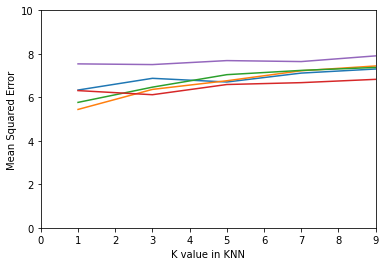

In [26]:
# KNN function
knn(x.copy())


KNN WITH NORMALIZATION

--------------------------FOLD 1 --------------------------------------------
MAE for k= 1  :  6.9628640776699005
MAE for k= 3  :  7.0903074433656945
MAE for k= 5  :  7.158417475728152
MAE for k= 7  :  7.401768377253815
MAE for k= 9  :  7.681213592233012

--------------------------FOLD 2 --------------------------------------------
MAE for k= 1  :  5.9413592233009735
MAE for k= 3  :  6.444190938511325
MAE for k= 5  :  6.780553398058254
MAE for k= 7  :  7.182302357836343
MAE for k= 9  :  7.48186084142395

--------------------------FOLD 3 --------------------------------------------
MAE for k= 1  :  6.4778640776698975
MAE for k= 3  :  7.042216828478966
MAE for k= 5  :  6.758330097087376
MAE for k= 7  :  7.029424410540911
MAE for k= 9  :  7.108786407766985

--------------------------FOLD 4 --------------------------------------------
MAE for k= 1  :  6.838786407766992
MAE for k= 3  :  6.504158576051779
MAE for k= 5  :  6.645631067961171
MAE for k= 7  :  6.565755894

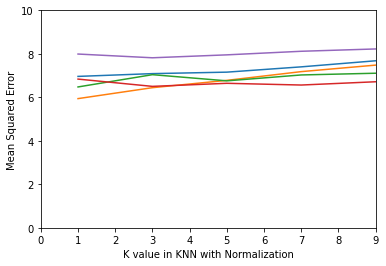

In [27]:
# KNN with normalization function
knn_with_normalization(x.copy())


WEIGHTED KNN

--------------------------FOLD 1 --------------------------------------------
MAE for k= 1  :  6.104417475728154
MAE for k= 3  :  6.156156028862015
MAE for k= 5  :  6.128188716780046
MAE for k= 7  :  6.247267001640452
MAE for k= 9  :  6.256475427688429

--------------------------FOLD 2 --------------------------------------------
MAE for k= 1  :  5.327135922330098
MAE for k= 3  :  5.390908299691315
MAE for k= 5  :  5.723842273972264
MAE for k= 7  :  5.854641028833058
MAE for k= 9  :  5.928954941321403

--------------------------FOLD 3 --------------------------------------------
MAE for k= 1  :  5.476359223300969
MAE for k= 3  :  5.686333822475895
MAE for k= 5  :  5.9966567296003
MAE for k= 7  :  5.954731500344837
MAE for k= 9  :  5.9322097352248315

--------------------------FOLD 4 --------------------------------------------
MAE for k= 1  :  6.303640776699031
MAE for k= 3  :  5.514630762228502
MAE for k= 5  :  5.616092319467644
MAE for k= 7  :  5.390414250544432
MAE for

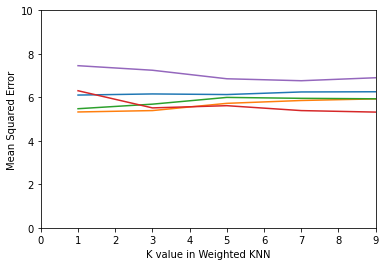

In [28]:
# Weighted KNN function
weighted_knn(x.copy())


WEIGHTED KNN WITH NORMALIZATION

--------------------------FOLD 1 --------------------------------------------
MAE for k= 1  :  6.731407766990289
MAE for k= 3  :  6.439195795693212
MAE for k= 5  :  6.603657868406925
MAE for k= 7  :  6.660813597486109
MAE for k= 9  :  6.807069647213366

--------------------------FOLD 2 --------------------------------------------
MAE for k= 1  :  5.825145631067962
MAE for k= 3  :  5.600877738052441
MAE for k= 5  :  6.070397187016803
MAE for k= 7  :  6.232454878016855
MAE for k= 9  :  6.282852033992239

--------------------------FOLD 3 --------------------------------------------
MAE for k= 1  :  6.18660194174757
MAE for k= 3  :  6.541490556228706
MAE for k= 5  :  6.321999342870664
MAE for k= 7  :  6.300403248631208
MAE for k= 9  :  6.322021933791188

--------------------------FOLD 4 --------------------------------------------
MAE for k= 1  :  6.832572815533982
MAE for k= 3  :  5.755115734169273
MAE for k= 5  :  5.754985961612893
MAE for k= 7  :  5.5569

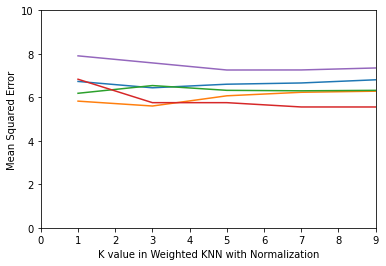

In [29]:
# Weighted KNN with normalization function
weighted_knn_with_normalization(x.copy())

## **Error Analysis for Regression**

Below you can see all of the accuracy values in one table.

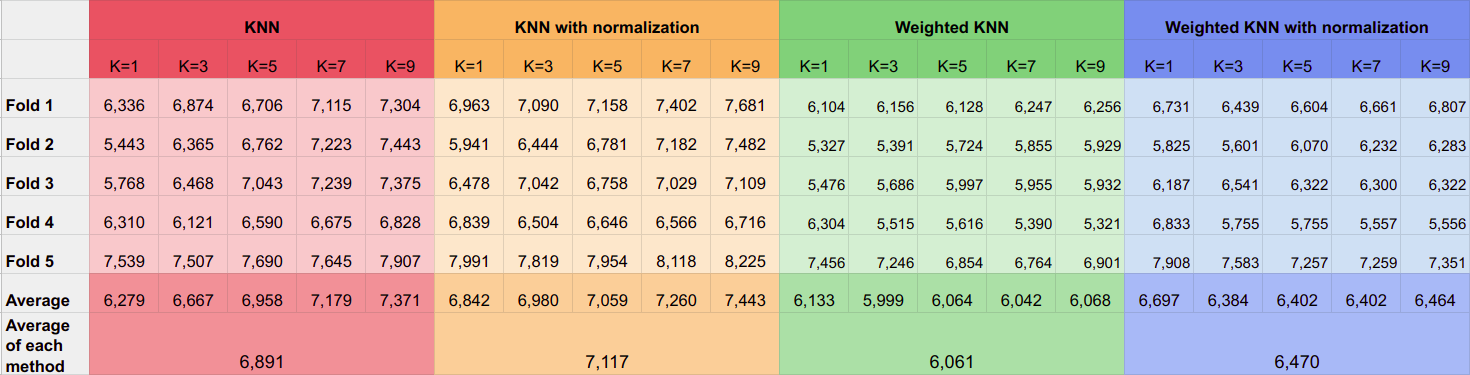

## **1.Performance** 
Compare performance of different feature normalization choices and investigate the effect of important system parameters (number of training samples used, k in k-NN, etc.). Wherever relevant, feel free to discuss computation time in addition to regression/estimation rate.

#### **Different Feature Normalization Choices** 

With different feature normalization choices we get different mean squared errors. Normalization is about getting features values to common range to prevent effect of too low or too high feature values. In this dataset we don't have discrete valued labels but continuous and we predict by getting mean of k nearest neighbor. For our case it seems normalization not improving the mean squared errors. With normalization we change the set that k nearest neighbors which are closest to point we trying to predict. With this change we might affect the prediction and it may be wrong. In our case normalization does not affects the accuracy in a good way.


|            |MAE|
|------------|--------------------|
|KNN         |6,891|
|KNN with normalization|7,117|
|Weighted KNN|6,061|
|Weighted KNN with normalization |6,470|



#### **Effect of Different Methods**

We have 4 different methods which are KNN, KNN with normalization, Weighted KNN and Weighted KNN with normalization. We can observe from table that lowest mean squared error is in Weighted KNN which is 6,061. Weighted KNN with normalization, KNN and KNN with normalization follows that respectively. We can say that weighted algorithms perform better and normalization not always perform better. With weighted algorithms there is way to achive more accurate model. In KNN we select K nearest neighbor and use euclidian distance to predict our value based on them. As we mentioned above using normalized features might select a different set of K neighbors than the ones chosen when unnormalized features were used so it may effect accuracy in a bad way.

#### **Effect of Important System Parameters**

* **Number of Training Samples**

??????????????

* **K in KNN**

We use 1,3,5,7,9 as k values in k-NN and calculate accuracy for every different k value. Below you can see average accuracy in all tests for different K values.

|        |**Average**|
|--------|-----------|
|K=1| 6,488|
|K=3| 6,507|
|K=5| 6,621|
|K=7| 6,721|
|K=9| 6,836|

We can see that they all close to each other but the best value is in k=1. It has 6,488 mean squared error and the errors increase with k values. Larger k value increases the mean squred error. For our situation k=1 is the best value.


#### **Computation Time**
Below we listed computation time as seconds versus algorithms. 
  
|            |Computation time (in seconds)|
|------------|--------------------|
|KNN         |              3.8380002|
|KNN with normalization|    3.8200011|
|Weighted KNN|              3.8130095|
|Weighted KNN with normalization |  3.7539989|

All four algorithms perform in a similiar time which is around 3.8 seconds. We can see that when we use normalization it affect algorithms with faster time in milliseconds. Our data is not very large and because of that there is not that much difference between algorithms.

